In [102]:
import os
import numpy as np
from matplotlib import pyplot as plt
import torch

from pruning_train import *
from pruning_prune import *
from pruning_main import count_zero_parameters

In [103]:
def compute_frobenius_norm(model):
    norm_squared = 0.0
    for param in model.parameters():
        norm_squared += torch.norm(param, p=2).pow(2) # dim=[0, 1]
    return torch.sqrt(norm_squared)

In [104]:
DIR = "/home/mateusz.pyla/stan/atelier/sharpness/pruning"
network_path_main = "resnet-9_cifar10-10k_sgd_0.01_50_mse_s8.pt"
strength = 0.1
network_path_max = f"pruned_magnitude_max_{strength}_nobnF_ON_resnet-9_cifar10-10k_sgd_0.01_50_mse_s8.pt"
network_path_min = f"pruned_magnitude_min_{strength}_nobnF_ON_resnet-9_cifar10-10k_sgd_0.01_50_mse_s8.pt"
device = "cuda"
train_dataset_name = "cifar10-10k"
test_datasets_names = ["cifar10t", "cifar10c_brightness2", "cifar10c_gaussian_noise4"]
loss_name = "mse"
train_batch_size = 64
test_batch_size = 1000

In [105]:
result_dir = os.path.abspath(os.getcwd())
dataset_dir = os.path.abspath(os.getcwd())

if not "RESULTS" in os.environ:
    os.environ["RESULTS"] = os.path.join(result_dir, "results")
if not "DATASETS" in os.environ:
    os.environ["DATASETS"] = os.path.join(dataset_dir, "data")

seed = 8
torch.manual_seed(seed)
np.random.seed(seed)

In [106]:
loss_fn, acc_fn = get_loss_and_acc(loss_name)
train_dataset, train_dataloader, test_datasets, test_dataloaders = prepare_data(train_dataset_name, test_datasets_names, loss_name, train_batch_size, test_batch_size)

In [107]:
main_network = ResNet9(input_shape=[32, 32, 3], output_shape=10, softmax=True).to(device)
main_network.load_state_dict(torch.load(os.path.join(DIR, network_path_main)))
main_network.eval()
min_network = ResNet9(input_shape=[32, 32, 3], output_shape=10, softmax=True).to(device)
min_network.load_state_dict(torch.load(os.path.join(DIR, network_path_min)))
min_network.eval()
max_network = ResNet9(input_shape=[32, 32, 3], output_shape=10, softmax=True).to(device)
max_network.load_state_dict(torch.load(os.path.join(DIR, network_path_max)))
max_network.eval()

ResNet9(
  (feature_extractor): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): SkipSequential(
      (layers): Sequential(
        (0): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          

In [109]:
main_network_norm, min_network_norm, max_network_norm = compute_frobenius_norm(main_network), compute_frobenius_norm(min_network), compute_frobenius_norm(max_network)

In [110]:
print(main_network.feature_extractor[0][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[1][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[2].layers[0][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[2].layers[1][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[3][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[4][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[5].layers[0][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[5].layers[1][1].running_mean.abs() < 0.0001)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False], device='cuda:0')
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        Fa

In [111]:
main_train_rez = compute_losses(main_network, [loss_fn, acc_fn], train_dataset, test_batch_size, no_grad=True)
main_test_rez = []
for k, test_dataset in enumerate(test_datasets):
    main_test_rez.append(compute_losses(main_network, [loss_fn, acc_fn], test_dataset, test_batch_size, no_grad=True))
print_compute_losses(main_train_rez, main_test_rez)
print(count_zero_parameters(main_network, relative=True))

train  | test_0 | test_1 | test_2
0.1933 | 0.3329 | 0.3331 | 0.3545
0.7209 | 0.4945 | 0.4983 | 0.4824
0.006115549391136925


In [112]:
min_train_rez = compute_losses(min_network, [loss_fn, acc_fn], train_dataset, test_batch_size, no_grad=True)
min_test_rez = []
for k, test_dataset in enumerate(test_datasets):
    min_test_rez.append(compute_losses(min_network, [loss_fn, acc_fn], test_dataset, test_batch_size, no_grad=True))
print_compute_losses(min_train_rez, min_test_rez)
print(count_zero_parameters(min_network, relative=True))

max_train_rez = compute_losses(max_network, [loss_fn, acc_fn], train_dataset, test_batch_size, no_grad=True)
max_test_rez = []
for k, test_dataset in enumerate(test_datasets):
    max_test_rez.append(compute_losses(max_network, [loss_fn, acc_fn], test_dataset, test_batch_size, no_grad=True))
print_compute_losses(max_train_rez, max_test_rez)
print(count_zero_parameters(max_network, relative=True))

train  | test_0 | test_1 | test_2
0.5116 | 0.5200 | 0.4819 | 0.4862
0.1884 | 0.1751 | 0.2068 | 0.1944
0.13325653157160738
train  | test_0 | test_1 | test_2
0.3432 | 0.3844 | 0.3888 | 0.3950
0.4285 | 0.3412 | 0.3370 | 0.3348
0.2850350626656751


In [121]:
main_network_modulelist, main_network_sparsity = [], []
for i, (name, module) in enumerate(main_network.named_modules()):
        params = sum(p.numel() for p in module.parameters())
        zero_params = count_zero_parameters(module, relative=False)
        main_network_modulelist.append(str(i) + "_" + module.__class__.__name__)
        if params == 0:
                main_network_sparsity.append(0.0)
                print(0, module)
        else:
                main_network_sparsity.append(zero_params / params)
                if isinstance(module, torch.nn.BatchNorm2d):
                        batch_norm_zero_params = count_zero_parameters(module, relative=False)
                        print(zero_params / params, module)
                print(zero_params / params)
        

0.006115549391136925
0.006118650155854276
0.0010416666666666667
0.0
0.015625 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.015625
0 ReLU(inplace=True)
0.002658139032815199
0.0025590337954939342
0.03125 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.03125
0 ReLU(inplace=True)
0 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
0.003354978354978355
0.003354978354978355
0.0033955627705627707
0.0033065915004336513
0.0546875 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.0546875
0 ReLU(inplace=True)
0.0033143939393939395
0.0032388334778837816
0.046875 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.046875
0 ReLU(inplace=True)
0.0033110119047619047
0.003221893972246314
0.0546875 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.0546875
0 ReLU(inplace=True)
0 MaxPool2d(kernel_size=2, stride=2, p

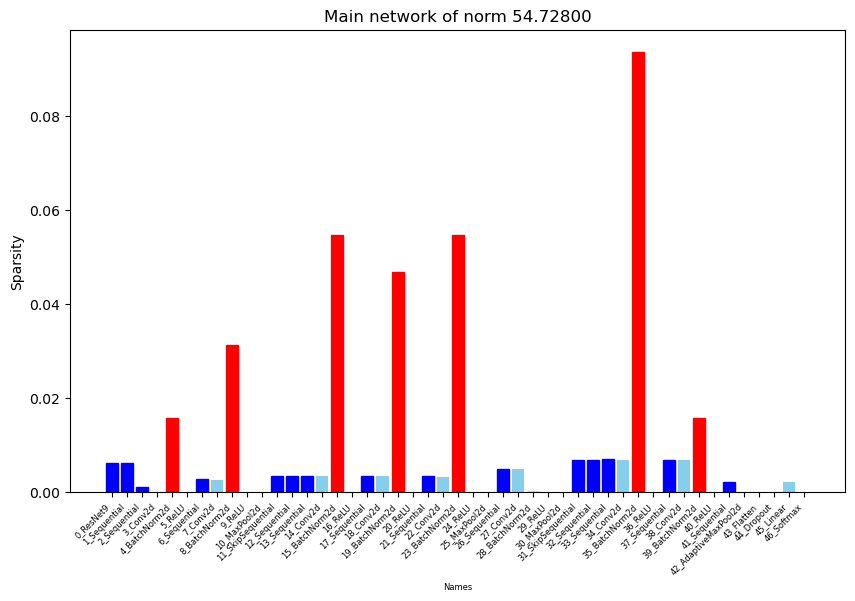

In [114]:
highlight_criterion = lambda name: name.endswith("BatchNorm2d")
bold_crietrion = lambda name: name.endswith("ResNet9") or name.endswith("Sequential")
plt.figure(figsize=(10, 6))
bars = plt.bar(main_network_modulelist, main_network_sparsity, color='skyblue')
for i, bar in enumerate(bars):
    if highlight_criterion(main_network_modulelist[i]):
        bar.set_color("red")
    elif bold_crietrion(main_network_modulelist[i]):
        bar.set_color("blue") # .set_linewidth(2)
plt.xlabel("Names", fontsize=6)
plt.ylabel("Sparsity")
plt.title(f"Main network of norm {main_network_norm:.5f}")
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis="x", labelsize=6)
plt.show()

In [119]:
print(main_network.feature_extractor[0][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[1][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[2].layers[0][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[2].layers[1][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[3][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[4][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[5].layers[0][1].running_mean.abs() < 0.0001)
print(main_network.feature_extractor[5].layers[1][1].running_mean.abs() < 0.0001)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False], device='cuda:0')
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        Fa

In [120]:
print(main_network.feature_extractor[0][1].running_var.abs() < 0.0001)
print(main_network.feature_extractor[1][1].running_var.abs() < 0.0001)
print(main_network.feature_extractor[2].layers[0][1].running_var.abs() < 0.0001)
print(main_network.feature_extractor[2].layers[1][1].running_var.abs() < 0.0001)
print(main_network.feature_extractor[3][1].running_var.abs() < 0.0001)
print(main_network.feature_extractor[4][1].running_var.abs() < 0.0001)
print(main_network.feature_extractor[5].layers[0][1].running_var.abs() < 0.0001)
print(main_network.feature_extractor[5].layers[1][1].running_var.abs() < 0.0001)

tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False], device='cuda:0')
tensor([False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        Fa

In [122]:
min_network_modulelist, min_network_sparsity = [], []
for i, (name, module) in enumerate(min_network.named_modules()):
        params = sum(p.numel() for p in module.parameters())
        zero_params = count_zero_parameters(module, relative=False)
        min_network_modulelist.append(str(i) + "_" + module.__class__.__name__)
        if params == 0:
                min_network_sparsity.append(0.0)
                print(0, module)
        else:
                min_network_sparsity.append(zero_params / params)
                if isinstance(module, torch.nn.BatchNorm2d):
                        batch_norm_zero_params = count_zero_parameters(module, relative=False)
                        print(zero_params / params, module)
                print(zero_params / params)

0.13325653157160738
0.1333407912039743
0.34427083333333336
0.34375
0.3515625 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.3515625
0 ReLU(inplace=True)
0.43601575993091535
0.4369448656845754
0.16796875 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.16796875
0 ReLU(inplace=True)
0 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
0.3437973484848485
0.3437973484848485
0.3438582251082251
0.3439871530789245
0.26953125 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.26953125
0 ReLU(inplace=True)
0.3437364718614719
0.3440074804856895
0.1875 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.1875
0 ReLU(inplace=True)
0.3104707792207792
0.31058922376409365
0.2421875 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.2421875
0 ReLU(inplace=True)
0 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

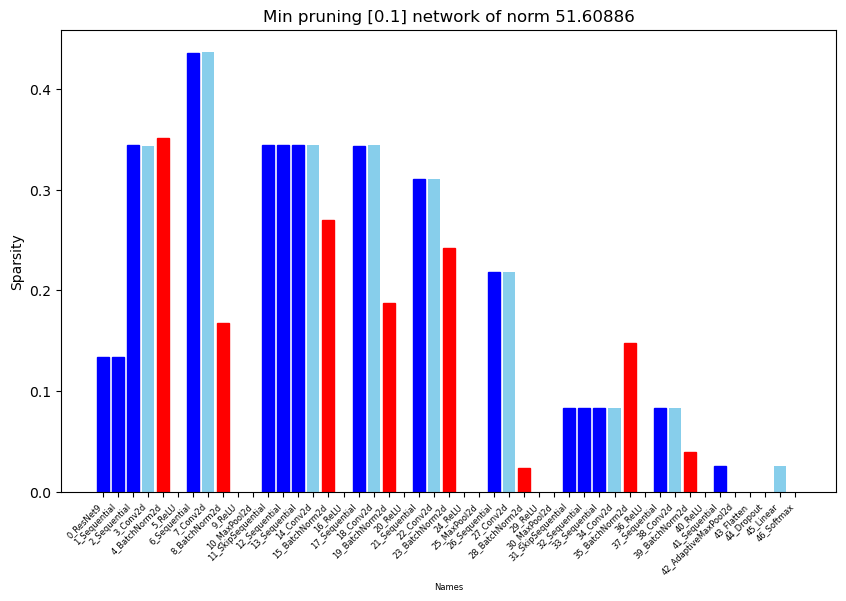

In [116]:
highlight_criterion = lambda name: name.endswith("BatchNorm2d")
bold_crietrion = lambda name: name.endswith("ResNet9") or name.endswith("Sequential")
plt.figure(figsize=(10, 6))
bars = plt.bar(min_network_modulelist, min_network_sparsity, color='skyblue')
for i, bar in enumerate(bars):
    if highlight_criterion(min_network_modulelist[i]):
        bar.set_color("red")
    elif bold_crietrion(min_network_modulelist[i]):
        bar.set_color("blue") # .set_linewidth(2)
plt.xlabel("Names", fontsize=6)
plt.ylabel("Sparsity")
plt.title(f"Min pruning [{strength}] network of norm {min_network_norm:.5f}")
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis="x", labelsize=6)
plt.show()

In [117]:
max_network_modulelist, max_network_sparsity = [], []
for i, (name, module) in enumerate(max_network.named_modules()):
        params = sum(p.numel() for p in module.parameters())
        zero_params = count_zero_parameters(module, relative=False)
        max_network_modulelist.append(str(i) + "_" + module.__class__.__name__)
        if params == 0:
                max_network_sparsity.append(0.0)
                print(0, module)
        else:
                max_network_sparsity.append(zero_params / params)
                if isinstance(module, torch.nn.BatchNorm2d):
                        print(zero_params / params, module)
                print(zero_params / params)

0.2850350626656751
0.28501272404052214
0.0010416666666666667
0.0
0.015625 BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.015625
0 ReLU(inplace=True)
0.002658139032815199
0.0025590337954939342
0.03125 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.03125
0 ReLU(inplace=True)
0 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
0.003354978354978355
0.003354978354978355
0.0033955627705627707
0.0033065915004336513
0.0546875 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.0546875
0 ReLU(inplace=True)
0.0033143939393939395
0.0032388334778837816
0.046875 BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.046875
0 ReLU(inplace=True)
0.0033110119047619047
0.003221893972246314
0.0546875 BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
0.0546875
0 ReLU(inplace=True)
0 MaxPool2d(kernel_size=2, stride=2, padd

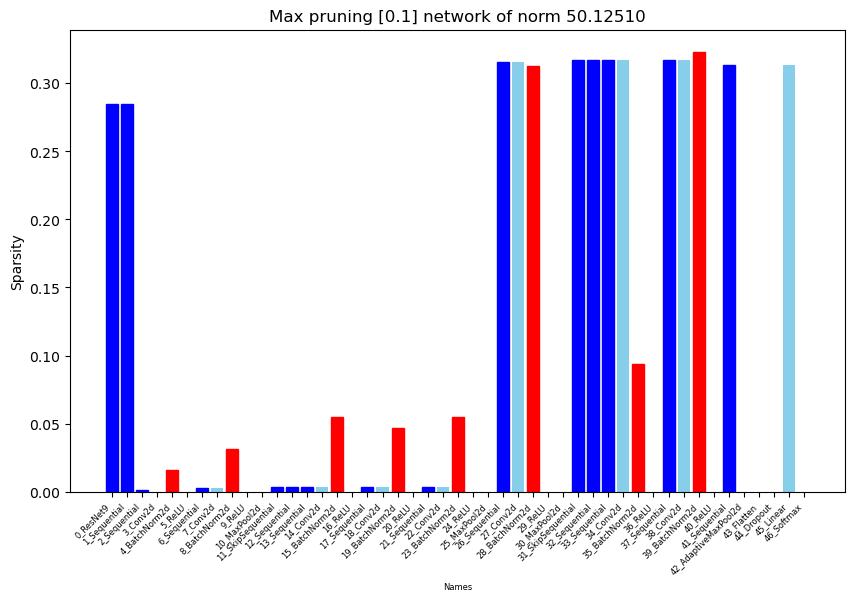

In [118]:
highlight_criterion = lambda name: name.endswith("BatchNorm2d")
bold_crietrion = lambda name: name.endswith("ResNet9") or name.endswith("Sequential")
plt.figure(figsize=(10, 6))
bars = plt.bar(max_network_modulelist, max_network_sparsity, color='skyblue')
for i, bar in enumerate(bars):
    if highlight_criterion(max_network_modulelist[i]):
        bar.set_color("red")
    elif bold_crietrion(max_network_modulelist[i]):
        bar.set_color("blue") # .set_linewidth(2)
plt.xlabel("Names", fontsize=6)
plt.ylabel("Sparsity")
plt.title(f"Max pruning [{strength}] network of norm {max_network_norm:.5f}")
plt.xticks(rotation=45, ha='right')
plt.tick_params(axis="x", labelsize=6)
plt.show()